In [1]:
import os
import time
import json
import h5py
import threading
from collections import defaultdict
from collections import Counter
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
from skimage.io import imread
from sklearn.model_selection import train_test_split
from skimage.segmentation import find_boundaries
from skimage.util import montage

from IPython.display import SVG
import tensorflow as tf
import keras.backend as K
from keras.utils.vis_utils import plot_model
from keras.utils.vis_utils import model_to_dot
from keras.utils import Sequence
from keras.models import load_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import AvgPool2D
from keras.layers import Cropping2D
from keras.layers import MaxPooling2D
from keras.layers import UpSampling2D
from keras.layers import ZeroPadding2D
from keras.layers import RepeatVector
from keras.layers import GaussianNoise
from keras.layers import Conv2DTranspose
from keras.layers import BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Reshape
from keras.layers import concatenate
from keras.layers import multiply
from keras.layers import maximum
from keras.layers import add
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import Iterator

from utils import get_datetime_now
from utils import reversed_recombined_holt_winters
from utils import rle_encode
from utils import rle_decode
from utils import masks_as_image
from utils import get_mask_weights

%matplotlib inline
%reload_ext autoreload
%autoreload 2

_EPSILON = K.epsilon()

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 16
BIGGEST_SIZE = 20
plt.rc('font', size=BIGGEST_SIZE)         # controls default text sizes
plt.rc('axes', titlesize=BIGGEST_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=BIGGEST_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)   # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)   # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGEST_SIZE)  # fontsize of the figure title

Using TensorFlow backend.


In [ ]:
[x.name for x in K.device_lib.list_local_devices() if x.name[:11] == '/device:GPU']

In [2]:
dir_ext = 'GCN_scSE_768_focaldice_deconv'
# Dict for saving all configuration data.
BASE_MODEL = "2018_1112_0051_06_GCN_scSE_384_focaldice_deconv"
# BASE_MODEL = None
GAUSSIAN_NOISE = None
NORMALIZE_INPUT_BATCH = True
DROPOUT = 0
LEARN_RATE = 0.0015
# LOSS_FUNCTION = "bce_soft_dice_loss"
# LOSS_FUNCTION_KWARGS = {"frac": 0.5, "mult": 1}
LOSS_FUNCTION = "focal_soft_dice_loss"
LOSS_FUNCTION_KWARGS = {"gamma": 2.0, "alpha": 0.25, "frac": 0.7, "mult": 10}
MASK_METHOD = "fullmasks"
IMG_SIZE = 768  # 768, 384, 192, 96
CROP_SIZE = 768  # 512, 256, 128, 64
EDGE_CROP = (IMG_SIZE - CROP_SIZE) // 8
BATCH_SIZE = 2
# INPUT_SHAPE = (CROP_SIZE, CROP_SIZE, 3)
INPUT_SHAPE = (None, None, 3)
# INPUT_SHAPE = (221, 221, 3)
# number of training images to use (-1 == use all)
TRAIN_IMG_COUNT = 2**14
# number of validation images to use (-1 == use all)
VALID_IMG_COUNT = -1
data_config = {
    'base_model': BASE_MODEL,
    'gaussian_noise': GAUSSIAN_NOISE,
    'normalize_input_batch': NORMALIZE_INPUT_BATCH,
    'dropout': DROPOUT,
    'learn_rate': LEARN_RATE,
    'loss_function': LOSS_FUNCTION,
    'loss_function_kwargs': LOSS_FUNCTION_KWARGS,
    'mask_method': MASK_METHOD,
    'img_size': IMG_SIZE,
    'crop_size': CROP_SIZE,
    'edge_crop': EDGE_CROP,
    'batch_size': BATCH_SIZE,
    'input_shape': INPUT_SHAPE,
    'train_img_count': TRAIN_IMG_COUNT,
    'valid_img_count': VALID_IMG_COUNT,
}

In [3]:
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i], padding_width=10, fill=[255, 255, 255]) for i in range(x.shape[3])], -1)
montage_pad = lambda x, *args, **kwargs: montage(x, padding_width=10, *args, **kwargs)

ship_dir = "/media/Borg_LS/DATA/geos/airbus/input/"
train_img_path = os.path.join(ship_dir, f"train_{IMG_SIZE}")
train_seg_file = os.path.join(ship_dir, f"{MASK_METHOD}_{IMG_SIZE}.h5")
datetime_now = get_datetime_now()
run_name = f"{datetime_now}_{dir_ext}"
out_dir = f"out/{run_name}/"

# Split into training and validation groups
We stratify by the number of boats appearing so we have nice balances in each set

In [4]:
def get_overlap_imgs(valid_df, overlap_df):
    overlap_imgs = []
    for name in valid_df['ImageId'].values:
        if name not in overlap_df['ImageId'].values:
            continue
        s = overlap_df.loc[name, 'duplicates']
        if not isinstance(s, float):
            if len(s) < 30: 
                continue
            for idx in s.split(): 
                overlap_imgs.append(idx)
    overlap_imgs = set(overlap_imgs)
    return list(overlap_imgs)

In [5]:
df_files = {
    96: (
        ('fullmasks_96', 0.1, 3), 
        ('fullmasks_192_down_96', 0.1, 3), 
        ('fullmasks_384_down_96', 0.1, 3), 
        ('fullmasks_768_down_96', 0.05, 5),
        ('background_stats', 10, 10),
    ),
    192: (
        ('fullmasks_192', 0.05, 5), 
        ('fullmasks_384_down_192', 0.05, 5), 
        ('fullmasks_768_down_192', 0.03, 5), 
        ('background_stats', 5, 10),
    ),
    384: (
        ('fullmasks_384', 0.1, 1), 
        ('fullmasks_768_down_384', 0.05, 10),
        ('background_stats', 5, 10),
    ),
    768: (
        ('fullmasks_768', 0.01, 1), 
        ('background_stats', 1, 10),
    )
}

In [6]:
test_size = 0.1
train_df = []
valid_df = []
df_dict = {}
for fname, val_multiplier, train_multiplier in df_files[IMG_SIZE]:
    df = pd.read_csv(os.path.join(ship_dir, f"{fname}.csv"))
    if val_multiplier >= 1:
        df = df[['ImageId', 'ClusterId', 'brier']]
        cluster_groups = defaultdict(list)
        for i, cluster_id in enumerate(df['ClusterId'].values):
            cluster_groups[cluster_id].append(i)
        print(fname, max(cluster_groups), min([len(vals) for vals in cluster_groups.values()]))
        val_indices = []
        for cluster_id, val in cluster_groups.items():
            idxes = np.random.choice(val, val_multiplier, replace=False)
            val_indices += idxes.tolist()
        val_indices = list(sorted(val_indices))
        valid_df.append(df.iloc[val_indices][['ImageId', 'ClusterId', 'brier']])
        df_dict[fname] = (df.drop(val_indices), train_multiplier)
        
    else:
        strat_key = 'ClusterId' if 'ClusterId' in df else 'counts'
        train_ids, valid_ids = train_test_split(df, test_size=val_multiplier, random_state=777, stratify=df['ClusterId'])
        train_df.append(train_ids[['ImageId', 'ClusterId', 'brier']])
        valid_df.append(valid_ids[['ImageId', 'ClusterId', 'brier']])

if len(valid_df) > 0:
    for v_df in valid_df:
        print(f"{v_df.shape[0]} validation samples")
    valid_df = pd.concat(valid_df, ignore_index=True)
    print(f"{valid_df.shape[0]} validation samples")

dups_file = os.path.join(ship_dir, 'duplicates.csv')
overlap_df = pd.read_csv(dups_file)
overlap_df.index = overlap_df['ImageId']
overlap_imgs = get_overlap_imgs(valid_df, overlap_df)
print(len(overlap_df), len(overlap_imgs))

if len(train_df) > 0:
    train_df = pd.concat(train_df, ignore_index=True)
#     train_df = train_df.sort_values(by=['ImageId'])
#     train_df = train_df.reset_index(drop=True)
    print('train_df', len(train_df))
    train_df.index = train_df['ImageId']
#     train_ids = [name for name in train_df['ImageId'].values if name not in overlap_imgs]
#     train_df = train_df.loc[train_ids]  # TODO: fix for future compatability.
#     print('train_df', len(train_df))
    overlap_ids = [name for name in train_df['ImageId'].values if name in overlap_imgs]
    train_df.drop(index=overlap_ids, inplace=True)  # TODO: fix for future compatability.
    print('train_df', len(train_df), len(overlap_ids))
    train_df = train_df.sort_values(by=['ImageId'])
    train_df = train_df.reset_index(drop=True)
#     print(f"{train_df.shape[0]} training samples")
# print(f"{train_df.shape[0]}/{valid_df.shape[0]} training/validation samples")

if len(df_dict) > 0:
    for fname, (df, t_mult) in df_dict.items():
        df.index = df['ImageId']
        print(len(df))
#         train_ids = [name for name in df['ImageId'].values if name not in overlap_imgs]
#         df = df.loc[train_ids]  # TODO: fix for future compatability.
#         print(len(df))
        overlap_ids = [name for name in df['ImageId'].values if name in overlap_imgs]
        df.drop(index=overlap_ids, inplace=True)  # TODO: fix for future compatability.
        print(len(df), len(overlap_ids))
        df = df.sort_values(by=['ImageId'])
        df = df.reset_index(drop=True)
        df_dict[fname] = (df, t_mult)

background_stats 168 46
420 validation samples
169 validation samples
589 validation samples
192555 1109
train_df 41529
train_df 41046 483
149747


/home/maddoxw/.virtualenvs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:51: FutureWarning: 'ImageId' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


149130 617


/home/maddoxw/.virtualenvs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:66: FutureWarning: 'ImageId' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


# Decode all the RLEs into Images
We make a generator to produce batches of images

In [7]:
def gamma_func(x):
    # x should be greater than -1 but less than 1
    # if x is 0, this function just x.
    return np.log((1 + x)/2) / np.log((1 - x)/2)

class DataGenerator(Sequence):
    """Generates data for Keras"""
    def __init__(self,
                 img_dir,
                 seg_file,
                 img_df=None,
                 cluster_groups=None,
                 img_size=768,
                 crop_size=None,
                 edge_crop=None,
                 batch_size=4,
                 n_channels=3,
                 n_classes=1,
                 n_samples=-1,
                 weights=None,
                 gamma_correction=0,
                 shuffle=True,
                 rotate=False,
                 ig_args=None,
                 dg_args=None,
                 seed=None,
                 drop_last=True
                 ):

        """Initialization"""
        self.lock = threading.Lock()
        
        if isinstance(img_size, tuple):
            assert img_size[0] == img_size[1]
            self.img_size = img_size[0]
        else:
            self.img_size = img_size
            
        if crop_size is None:
            crop_size = img_size
        if isinstance(crop_size, tuple):
            assert crop_size[0] == crop_size[1]
            self.crop_size = crop_size[0]
        else:
            self.crop_size = crop_size
        
        assert self.crop_size <= self.img_size
        
        if edge_crop is None:
            self.edge_crop = (self.img_size - self.crop_size) // 8
            
        self.img_dir = img_dir
        self.seg_file = seg_file
        self.shuffle = shuffle
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.drop_last = drop_last
        
        if weights is None:
            self.use_weights = False
            self.img_ids_default = np.array([]) if img_df is None else img_df['ImageId'].values
            self.max_samples = len(self.img_ids_default)
        else: 
            self.use_weights = True
            cluster_dfs = []
            if cluster_groups is not None:
                for cluster_group_name, (cluster_df, multiplier) in cluster_groups.items():
                    assert weights in cluster_df
                    cluster_dfs.append(cluster_df)    
            if img_df is not None:
                assert weights in img_df
                cluster_dfs.append(img_df)
            
            self.img_df = pd.concat(cluster_dfs, ignore_index=True)
            self.img_df = self.img_df.sort_values(by=['ImageId'])
            self.img_df = self.img_df.reset_index(drop=True)
            self.img_ids_default = self.img_df['ImageId'].values
            self.max_samples = len(self.img_ids_default)
            self.loss_weights = self.img_df[weights].values
            self.all_weight = np.sum(self.loss_weights)
            self.norm_weights = self.loss_weights / self.all_weight
            cluster_groups = None
        
        if cluster_groups is None:
            self.cluster_groups = None
            self.img_ids = self.img_ids_default
        else:
            self.cluster_groups = {}
            self.aux_img_ids = {}
            for cluster_group_name, (cluster_df, multiplier) in cluster_groups.items():
                cluster = defaultdict(list)
                for i, cluster_id in enumerate(cluster_df['ClusterId'].values):
                    cluster[cluster_id].append(i)
                self.max_samples += len(cluster) * multiplier
                self.cluster_groups[cluster_group_name] = (cluster, multiplier)
                self.aux_img_ids[cluster_group_name] = cluster_df['ImageId'].values

        self.n_samples = self.max_samples if n_samples in (None, -1) else min(n_samples, self.max_samples)
        self.batch_size = self.n_samples if batch_size in (None, -1) else min(batch_size, self.n_samples)

        self.augment = True
        if dg_args is not None and ig_args is None:
            self.image_gen = ImageDataGenerator(**dg_args)
            self.label_gen = ImageDataGenerator(**dg_args)
        elif dg_args is None and ig_args is not None: # Validation
            self.image_gen = ImageDataGenerator(**ig_args)
            self.label_gen = ImageDataGenerator()
        elif dg_args is not None and ig_args is not None:
            ig_args = dict(**ig_args, **dg_args)
            self.image_gen = ImageDataGenerator(**ig_args)
            self.label_gen = ImageDataGenerator(**dg_args)
        else:
            self.augment = False  # to get x_train_mean

        self.gamma_correction = gamma_correction
        self.rotate = rotate
        
        np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
        self.on_epoch_end()
        
    def next(self):
        """For python 2.x.

        # Returns
            The next batch.
        """
        # Keeps under lock only the mechanism which advances
        # the indexing of each batch.
        with self.lock:
            index_array = next(self.index_generator)
        # The transformation of images is not under thread lock
        # so it can be done in parallel
        return self._get_batches_of_transformed_samples(index_array)

    def __len__(self):
        """Denotes the number of batches per epoch"""
        n_samples = self.n_samples if self.drop_last else self.n_samples + self.batch_size - 1
        return n_samples // self.batch_size

    def __getitem__(self, index):
        """Generate one batch of data"""
        # Generate indexes of the batch
        index_array = self.index_array[self.batch_size * index: self.batch_size * (index + 1)]
        # Generate and return batch
        return self._get_batches_of_transformed_samples(index_array)

    def on_epoch_end(self):
        """Updates indexes after each epoch"""


        if self.cluster_groups is not None:
            self.img_ids = self.img_ids_default
            for cluster_group_name, (cluster_group, multiplier) in self.cluster_groups.items():
                aux_img_ids = self.aux_img_ids[cluster_group_name]
                for cluster_id, cluster in cluster_group.items():
                    img_indexes = np.random.choice(cluster, multiplier, replace=False)
                    img_id = aux_img_ids[img_indexes]
                    self.img_ids = np.append(self.img_ids, img_id)
                    
            self.img_ids = np.array(self.img_ids)
            assert len(self.img_ids) <= self.max_samples
            self.index_array = np.arange(len(self.img_ids))
        else:
            if self.n_samples < self.max_samples:
                if self.use_weights:
                    self.norm_weights = self.loss_weights / np.sum(self.loss_weights)
                    self.index_array = np.random.choice(self.max_samples, self.n_samples, replace=False, p=self.norm_weights)
                else:
                    self.index_array = np.random.choice(self.max_samples, self.n_samples, replace=False, p=None)
            else:
                self.index_array = np.arange(self.max_samples)

        if self.shuffle:
            np.random.shuffle(self.index_array)

    def get_next_batch(self, index_array):
        """Generates data containing batch_size samples"""
        
        x_batch = np.empty((len(index_array), self.img_size, self.img_size, self.n_channels), dtype=np.uint8)
        y_batch = np.empty((len(index_array), self.img_size, self.img_size, self.n_classes), dtype=np.float32)
        with h5py.File(self.seg_file, 'r') as mask_1:
            for i, idx in enumerate(index_array):
                x_batch[i] = cv.cvtColor(cv.imread(os.path.join(self.img_dir, self.img_ids[idx])), cv.COLOR_BGR2RGB)
                try:
                    y_batch[i] = mask_1[self.img_ids[idx]][:] * 1
                except KeyError:
                    y_batch[i] = np.zeros((self.img_size, self.img_size, self.n_classes), dtype=np.float32)
        return x_batch, y_batch
    
    def gamma_correct_batch(self, x_batch):
        # cv.LUT requires image to be uint8, so we do this first before the other augmentations.
        lookUpTable = np.empty((1, 256), np.uint8)
        
        for i in range(len(x_batch)):
            gamma = gamma_func(np.random.uniform(-self.gamma_correction, self.gamma_correction))
            for j in range(256):
                lookUpTable[0, j] = np.clip(pow(j / 255.0, gamma) * 255.0, 0, 255)
            x_batch[i] = cv.LUT(x_batch[i], lookUpTable)
            
        return x_batch
    
    def augment_batch(self, x_batch, y_batch):
        seed = np.random.choice(range(9999))
        x_batch_aug = self.image_gen.flow(x_batch, batch_size=self.batch_size, seed=seed, shuffle=False).next()
        y_batch_aug = self.label_gen.flow(y_batch, batch_size=self.batch_size, seed=seed, shuffle=False).next()
        return x_batch_aug, (y_batch_aug > 0.5) * 1.0 # make sure mask is still zeros and ones.
    
    def rotate_batch(self, x_batch, y_batch):
        r90s = np.random.randint(0, 4, self.batch_size)
        for i, k in enumerate(r90s):        
            x_batch[i] = np.rot90(x_batch[i], k, axes=(0, 1))
            y_batch[i] = np.rot90(y_batch[i], k, axes=(0, 1))
        return x_batch, y_batch

    def crop_batch(self, x_batch, y_batch):
        x_batch_crops = np.empty((self.batch_size, self.crop_size, self.crop_size, self.n_channels), dtype=np.float32)
        y_batch_crops = np.empty((self.batch_size, self.crop_size, self.crop_size, self.n_classes), dtype=np.float32)
        for i in range(self.batch_size):
            x = np.random.randint(self.edge_crop, self.img_size - self.crop_size - self.edge_crop + 1)
            y = np.random.randint(self.edge_crop, self.img_size - self.crop_size - self.edge_crop + 1)
            x_batch_crops[i] = x_batch[i, y:(y + self.crop_size), x:(x + self.crop_size), :]
            y_batch_crops[i] = y_batch[i, y:(y + self.crop_size), x:(x + self.crop_size), :]
        return x_batch_crops, y_batch_crops
        
    def _get_batches_of_transformed_samples(self, index_array):
        x_batch, y_batch = self.get_next_batch(index_array)
        
        if self.gamma_correction != 0:
            x_batch = self.gamma_correct_batch(x_batch)
        x_batch = x_batch.astype(np.float32) / 255.0
        
        if self.augment:
            x_batch, y_batch = self.augment_batch(x_batch, y_batch)
        if self.rotate:  # Rotate (by 0, 90, 180, or 270)
            x_batch, y_batch = self.rotate_batch(x_batch, y_batch)
        if self.crop_size < self.img_size:  # Crop
            x_batch, y_batch = self.crop_batch(x_batch, y_batch)
        return x_batch, y_batch


In [13]:
def max_rotation(edge_crop=EDGE_CROP, img_size=IMG_SIZE, crop_size=CROP_SIZE):
    return np.arccos(np.sqrt((crop_size + 2 * edge_crop) / img_size)) * 180.0 / np.pi

# def per_channel_rotation(x, angle):
#     return rotate(x, angle, axes=(1, 2))

# def rotate(image, angle, axes=(0, 1)):
#     if angle % 90 != 0:
#         raise Exception('Angle must be a multiple of 90.')
#     k = angle // 90
#     return np.rot90(image, k, axes=axes)

# def rotation_wrapper():
#     if IMG_SIZE > CROP_SIZE:
#         rotation = max_rotation
#     elif IMG_SIZE == CROP_SIZE:
#         rotation = 
#     def rotation()

In [ ]:
img_size = 24
crop_size = 16
cw_max = (img_size - crop_size) // 2
for cw in range(cw_max + 1):
    print(cw, max_rotation(cw, img_size, crop_size))

In [ ]:
img_size = 384
crop_size = 256
cw_max = (img_size - crop_size) // 2
for cw in range(cw_max + 1):
    print(cw, max_rotation(cw, img_size, crop_size))

In [ ]:
def zero_center(mean):
    def closure(x):
        return x - mean
    return closure

train_mean_gen = DataGenerator(
    train_img_path, 
    train_seg_file, 
    img_df=train_df, 
    img_size=IMG_SIZE, 
    batch_size=32, 
    n_samples=-1, 
    shuffle=False,
    seed=777)

n_batches = len(train_mean_gen)
print(n_batches)
x_train_mean = np.zeros((3,))
ii = 0
for ii in range(n_batches):
    x_train, y_train = train_mean_gen[ii]
    x_train_mean += x_train.mean(axis=(0, 1, 2))
    ii += 1
    if ii % 100 == 0:
        print(ii, x_train_mean)
x_train_mean /= n_batches
x_train_mean

# Augment Data

In [8]:
# These args are applied to both training inputs and training outputs.
dg_args = dict(
#     height_shift_range = 32, # If random cropping, don't need to shift
#     width_shift_range = 32, # If random cropping, don't need to shift
#     shear_range = 0.01,
#     zoom_range = [0.9, 1.25], 
    horizontal_flip = True, 
    vertical_flip = True,
#     rotation_range = max_rotation(), 
    fill_mode = 'reflect',
    data_format = 'channels_last'
)

# These args are applied to both the training inputs and validation inputs.
# ig_args = dict(
#     samplewise_center=False, 
#     samplewise_std_normalization=False, 
#     preprocessing_function=zero_center(x_train_mean)
# )

train_gen = DataGenerator(
    train_img_path, 
    train_seg_file, 
    img_df=train_df, 
#     img_df=None,
    cluster_groups=df_dict,
    img_size=IMG_SIZE, 
    crop_size=CROP_SIZE,
    batch_size=BATCH_SIZE, 
    n_samples=TRAIN_IMG_COUNT,
    weights='brier',
#     weights=None,
    gamma_correction=0.1,
    shuffle=True,
    rotate=True,
    seed=777, 
    dg_args=dg_args, 
    ig_args=None)

valid_gen = DataGenerator(
    train_img_path, 
    train_seg_file, 
    img_df=valid_df, 
    img_size=IMG_SIZE, 
    crop_size=CROP_SIZE,
    batch_size=VALID_IMG_COUNT, 
    n_samples=VALID_IMG_COUNT, 
    shuffle=True,
    seed=777, 
    ig_args=None)

In [9]:
len(train_gen), train_gen.img_ids_default.shape, train_gen.img_ids.shape, train_gen.index_array.shape, train_gen.n_samples, train_gen.max_samples, train_gen.batch_size

(8192, (190176,), (190176,), (16384,), 16384, 190176, 2)

In [10]:
x_train, y_train = train_gen[0]
print(x_train.shape, x_train.dtype, x_train.min(), x_train.max(), x_train.mean(axis=(0, 1, 2)))
print(y_train.shape, y_train.dtype, y_train.min(), y_train.max(), y_train.mean(axis=(0, 1, 2)))

(8, 384, 384, 3) float32 0.0 1.0 [0.3649771  0.40744314 0.38481227]
(8, 384, 384, 1) float64 0.0 1.0 [0.00720808]


In [10]:
x_valid, y_valid = valid_gen[0]
print(x_valid.shape, x_valid.dtype, x_valid.min(), x_valid.max(), x_valid.astype(np.float64).mean(axis=(0, 1, 2)))
print(y_valid.shape, y_valid.dtype, y_valid.min(), y_valid.max(), y_valid.mean(axis=(0, 1, 2)))

(589, 768, 768, 3) float32 0.0 1.0 [0.23151543 0.3188913  0.33952624]
(589, 768, 768, 1) float32 0.0 1.0 [0.00364181]


In [12]:
[(i + 1, idx, train_gen.img_ids[idx]) for i, idx in enumerate(train_gen.index_array[32:48])]

[(1, 113264, '913769186.jpg'),
 (2, 139972, 'b5391d116.jpg'),
 (3, 7953, '09a96dd34.jpg'),
 (4, 99805, '7f522b4c9_1_384.jpg'),
 (5, 145827, 'bd4e80911.jpg'),
 (6, 93099, '762a4b1bd.jpg'),
 (7, 71325, '59bf84db8.jpg'),
 (8, 46269, '3975f9d0b_3.jpg'),
 (9, 162225, 'd3e695186.jpg'),
 (10, 109627, '8c710fd82.jpg'),
 (11, 191076, 'fb747a822.jpg'),
 (12, 192458, 'fd52a41a4.jpg'),
 (13, 155091, 'ca17a704a.jpg'),
 (14, 176538, 'e77e71b8d_8.jpg'),
 (15, 49283, '3d549b3e5.jpg'),
 (16, 33243, '28d97442a.jpg')]

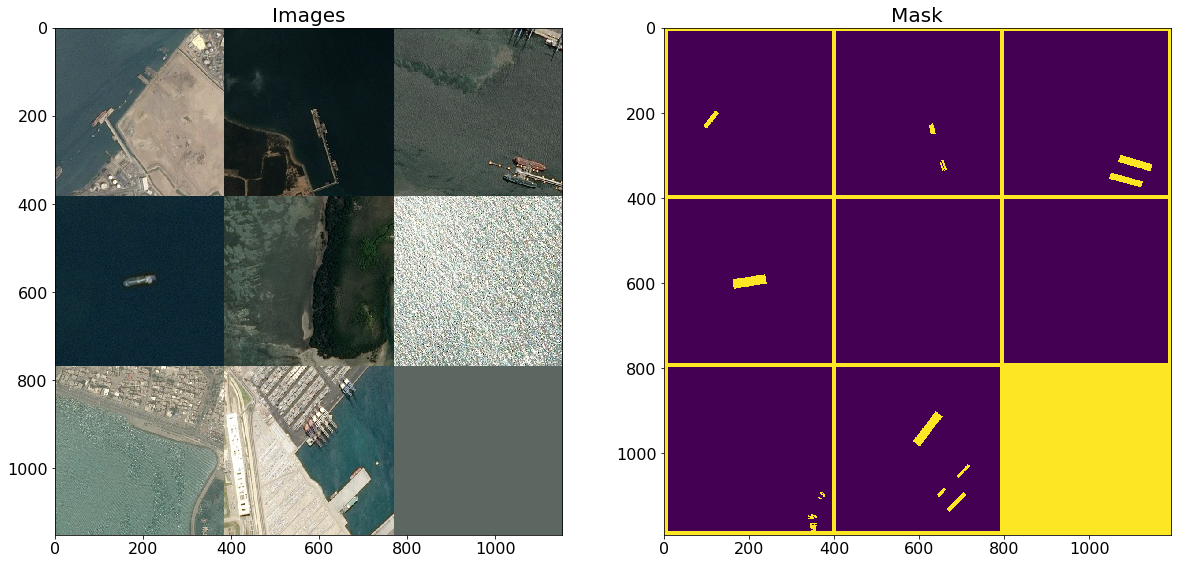

In [12]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize = (20, 30))
ax1.imshow(montage(x_train[:16], multichannel=True))
ax1.set_title('Images')
ax2.imshow(montage_pad(y_train[:16, ..., 0], fill=1))
ax2.set_title('Mask');

# Build a Model
Here we use a slight deviation on the U-Net standard

In [ ]:
def conv_block(inputs, direction, filters, k, normalize=False, activation='relu', dropout=0, idx='1', **conv2d_kwargs):
    pre = f'{direction}_block{filters}/'
    h = Conv2D(filters, k, name=pre+f'conv{idx}', **conv2d_kwargs)(inputs)
    h = BatchNormalization(axis=-1, name=pre+f'norm{idx}')(h) if normalize else h
    h = Activation(activation, name=pre+f'act{idx}')(h) if activation else h
    h = Dropout(dropout, name=pre+f'drop{idx}')(h) if dropout > 0 else h
    return h

def deconv_block(inputs, direction, filters, k, normalize=False, activation=None, dropout=0, idx='0', **conv2d_kwargs):
    pre = f'{direction}_block{filters}/'
    h = Conv2DTranspose(filters, k, strides=(2, 2), name=pre+f'deconv{idx}', **conv2d_kwargs)(inputs)
    h = BatchNormalization(axis=-1, name=pre+f'norm{idx}')(h) if normalize else h
    h = Activation(activation, name=pre+f'act{idx}')(h) if activation else h
    h = Dropout(dropout, name=pre+f'drop{idx}')(h) if dropout > 0 else h
    return h

def upsamp_block(inputs, direction, filters, normalize=False, activation=None, dropout=0, idx='0'):
    pre = f'{direction}_block{filters}/'
    h = UpSampling2D(size=(2, 2), name=pre+f'upsamp{idx}')(inputs)
    h = BatchNormalization(axis=-1, name=pre+f'norm{idx}')(h) if normalize else h
    h = Activation(activation, name=pre+f'act{idx}')(h) if activation else h
    h = Dropout(dropout, name=pre+f'drop{idx}')(h) if dropout > 0 else h
    return h

start_size = 8
size1 = start_size * 2 ** 0
size2 = start_size * 2 ** 1
size3 = start_size * 2 ** 2
size4 = start_size * 2 ** 3
size5 = start_size * 2 ** 4
size6 = start_size * 2 ** 5

conv2d_kwargs = dict(padding='same', kernel_initializer='he_normal')

# input_img = Input((384, 384, 3), name='input/image')
input_img = Input(INPUT_SHAPE, name='input/image')
inp = input_img
if GAUSSIAN_NOISE:
    inp = GaussianNoise(GAUSSIAN_NOISE, name='input/noise')(inp)
if NORMALIZE_INPUT_BATCH:
    inp = BatchNormalization(axis=-1, name='input/norm')(inp)

# a01 = conv2_block(inp, 'dn', size1, (3, 3), normalize=(True, True), **conv2d_kwargs)
# p01 = MaxPooling2D(pool_size=(2, 2), name=f'dn_block{size1}/pool')(a01)

# a02 = conv2_block(inp, 'dn', size2, (3, 3), normalize=(True, True), **conv2d_kwargs)
# p02 = MaxPooling2D(pool_size=(2, 2), name=f'dn_block{size2}/pool')(a02)

a03 = conv_block(inp, 'dn', size3, (3, 3), normalize=True, idx='1', **conv2d_kwargs)
a03 = conv_block(a03, 'dn', size3, (3, 3), normalize=True, idx='2', **conv2d_kwargs)
# a03 = conv2_block(inp, 'dn', size3, (3, 3), normalize=(True, True), **conv2d_kwargs)
p03 = MaxPooling2D(pool_size=(2, 2), name=f'dn_block{size3}/pool')(a03)

a04 = conv_block(p03, 'dn', size4, (3, 3), normalize=True, idx='1', **conv2d_kwargs)
a04 = conv_block(a04, 'dn', size4, (3, 3), normalize=True, idx='2', **conv2d_kwargs)
# a04 = conv2_block(p03, 'dn', size4, (3, 3), normalize=(True, True), **conv2d_kwargs)
p04 = MaxPooling2D(pool_size=(2, 2), name=f'dn_block{size4}/pool')(a04)

a05 = conv_block(p04, 'dn', size5, (3, 3), normalize=True, idx='1', **conv2d_kwargs)
a05 = conv_block(a05, 'dn', size5, (3, 3), normalize=True, idx='2', **conv2d_kwargs)
# a05 = conv2_block(p04, 'dn', size5, (3, 3), normalize=(True, True), **conv2d_kwargs)
p05 = MaxPooling2D(pool_size=(2, 2), name=f'dn_block{size5}/pool')(a05)

a06 = conv_block(p05, 'dn', size6, (3, 3), normalize=True, idx='1', **conv2d_kwargs)
a60 = conv_block(a06, 'dn', size6, (3, 3), normalize=True, idx='2', **conv2d_kwargs)
# a60 = conv2_block(p05, 'dn', size6, (3, 3), normalize=(True, True), **conv2d_kwargs)

t50 = upsamp_block(a60, 'up', size5, normalize=False, idx='0')
# t50 = deconv_block(a60, 'up', size5, (2, 2), normalize=True, idx=0, **conv2d_kwargs)
m50 = concatenate([a05, t50], axis=3, name=f'up_block{size5}/merge')
a50 = conv_block(m50, 'up', size5, (3, 3), normalize=True, idx='1', **conv2d_kwargs)
a50 = conv_block(a50, 'up', size5, (3, 3), normalize=True, idx='2', **conv2d_kwargs)
# a50 = conv2_block(m50, 'up', size5, (3, 3), normalize=(True, True), **conv2d_kwargs)

t40 = upsamp_block(a50, 'up', size4, normalize=False, idx='0')
# t40 = deconv_block(a50, 'up', size4, (2, 2), normalize=True, idx=0, **conv2d_kwargs)
m40 = concatenate([a04, t40], axis=3, name=f'up_block{size4}/merge')
a40 = conv_block(m40, 'up', size4, (3, 3), normalize=True, idx='1', **conv2d_kwargs)
a40 = conv_block(a40, 'up', size4, (3, 3), normalize=True, idx='2', **conv2d_kwargs)
# a40 = conv2_block(m40, 'up', size4, (3, 3), normalize=(True, True), **conv2d_kwargs)

t30 = upsamp_block(a40, 'up', size3, normalize=False, idx='0')
# t30 = deconv_block(a40, 'up', size3, (2, 2), normalize=True, idx=0, **conv2d_kwargs)
m30 = concatenate([a03, t30], axis=3, name=f'up_block{size3}/merge')
a30 = conv_block(m30, 'up', size3, (3, 3), normalize=True, idx='1', **conv2d_kwargs)
a30 = conv_block(a30, 'up', size3, (3, 3), normalize=True, idx='2', **conv2d_kwargs)
# a30 = conv2_block(m30, 'up', size3, (3, 3), normalize=(True, True), **conv2d_kwargs)

# t20 = deconv_block(a30, 'up', size3, (2, 2), normalize=True, idx=0, **conv2d_kwargs)
# m20 = concatenate([a02, t20], axis=3, name=f'up_block{size2}/merge')
# a20 = conv2_block(m20, 'up', size2, (3, 3), normalize=(True, True), **conv2d_kwargs)

# t10 = deconv_block(a20, 'up', size3, (2, 2), normalize=True, idx=0, **conv2d_kwargs)
# m10 = concatenate([a01, t10], axis=3, name=f'up_block{size1}/merge')
# a10 = conv2_block(m10, 'up', size1, (3, 3), normalize=(True, True), **conv2d_kwargs)

# d = Conv2D(1, (1, 1), activation='sigmoid', name='output/conv_act')(a30)
d = Conv2D(1, (1, 1), activation='linear', name='output/conv')(a30)
d = Activation('sigmoid', name='output/act')(d)

seg_model = Model(inputs=[input_img], outputs=[d])
seg_model.summary()

### Unet + GCN

In [13]:
def conv_block(inputs, direction, filters, k=3, normalize=False, activation='relu', dropout=0, idx='1', **conv2d_kwargs):
    pre = f'{direction}_block{filters}/'
    h = Conv2D(filters, k, name=pre+f'conv{idx}', **conv2d_kwargs)(inputs)
    h = BatchNormalization(axis=-1, name=pre+f'norm{idx}')(h) if normalize else h
    h = Activation(activation, name=pre+f'act{idx}')(h) if activation else h
    h = Dropout(dropout, name=pre+f'drop{idx}')(h) if dropout > 0 else h
    return h

def deconv_block(inputs, direction, filters, k=3, normalize=False, activation=None, dropout=0, idx='0', **conv2d_kwargs):
    pre = f'{direction}_block{filters}/'
    h = Conv2DTranspose(filters, k, strides=2, name=pre+f'deconv{idx}', **conv2d_kwargs)(inputs)
    h = BatchNormalization(axis=-1, name=pre+f'norm{idx}')(h) if normalize else h
    h = Activation(activation, name=pre+f'act{idx}')(h) if activation else h
    h = Dropout(dropout, name=pre+f'drop{idx}')(h) if dropout > 0 else h
    return h

def upsamp_block(inputs, direction, filters, normalize=False, activation=None, dropout=0, idx='0'):
    pre = f'{direction}_block{filters}/'
    h = UpSampling2D(size=(2, 2), name=pre+f'upsamp{idx}')(inputs)
    h = BatchNormalization(axis=-1, name=pre+f'norm{idx}')(h) if normalize else h
    h = Activation(activation, name=pre+f'act{idx}')(h) if activation else h
    h = Dropout(dropout, name=pre+f'drop{idx}')(h) if dropout > 0 else h
    return h

def gcn_block(inp, direction, f, k=3, normalize=True, activation=None, **conv2d_kwargs):
    pre = f'{direction}_gcn/'
    c11 = conv_block(inp, pre, f, (k, 1), normalize=normalize, activation=activation, idx='A1', **conv2d_kwargs)
    c12 = conv_block(c11, pre, f, (1, k), normalize=normalize, activation=activation, idx='A2', **conv2d_kwargs)
    c21 = conv_block(inp, pre, f, (1, k), normalize=normalize, activation=activation, idx='B1', **conv2d_kwargs)
    c22 = conv_block(c21, pre, f, (k, 1), normalize=normalize, activation=activation, idx='B2', **conv2d_kwargs)
    merged = add([c12, c22], name=pre + f'add')
    return merged

def br_block(inp, direction, filters, k=3, normalize=True, activation='relu', **conv2d_kwargs):
    pre = f'{direction}_br/'
    c11 = conv_block(inp, pre, filters, (k, k), normalize=normalize, activation=activation, idx='1', **conv2d_kwargs)
    c12 = conv_block(c11, pre, filters, (k, k), normalize=normalize, activation=None, idx='2', **conv2d_kwargs)
    merged = add([inp, c12], name=pre + f'add')
    return merged

internal_channels = 32
start_size = 8
size1 = start_size * 2 ** 0
size2 = start_size * 2 ** 1
size3 = start_size * 2 ** 2
size4 = start_size * 2 ** 3
size5 = start_size * 2 ** 4
size6 = start_size * 2 ** 5

conv2d_kwargs = dict(padding='same', kernel_initializer='he_normal')

add_norm = True
input_img = Input((384, 384, 3), name='input/image')
input_img = Input(INPUT_SHAPE, name='input/image')
inp = input_img
if GAUSSIAN_NOISE:
    inp = GaussianNoise(GAUSSIAN_NOISE, name='input/noise')(inp)
if NORMALIZE_INPUT_BATCH:
    inp = BatchNormalization(axis=-1, name='input/norm')(inp)

# a01 = conv2_block(inp, 'dn', size1, (3, 3), normalize=(True, True), **conv2d_kwargs)
# p01 = MaxPooling2D(pool_size=(2, 2), name=f'dn_block{size1}/pool')(a01)

# a02 = conv2_block(inp, 'dn', size2, (3, 3), normalize=(True, True), **conv2d_kwargs)
# p02 = MaxPooling2D(pool_size=(2, 2), name=f'dn_block{size2}/pool')(a02)

# a02 = conv_block(inp, 'dn', size2, (7, 7), normalize=False, idx='1', **conv2d_kwargs)

pri = conv_block(inp, 'dn', size3, (7, 7), normalize=add_norm, idx='1', **conv2d_kwargs)

a03 = conv_block(pri, 'dn3', size3, k=3, normalize=add_norm, idx='1', **conv2d_kwargs)
p03 = MaxPooling2D(pool_size=2, strides=2, name=f'dn3_block{size3}/pool')(a03)

g03 = gcn_block(p03, 'dn3', internal_channels, k=7, normalize=add_norm, activation=None, **conv2d_kwargs)
b03 = br_block(g03, 'dn3', internal_channels, normalize=add_norm, **conv2d_kwargs)

a04 = conv_block(p03, 'dn4', size4, k=3, normalize=True, idx='1', **conv2d_kwargs)
p04 = MaxPooling2D(pool_size=2, strides=2, name=f'dn4_block{size4}/pool')(a04)

g04 = gcn_block(p04, 'dn4', internal_channels, k=7, normalize=add_norm, activation=None, **conv2d_kwargs)
b04 = br_block(g04, 'dn4', internal_channels, normalize=add_norm, **conv2d_kwargs)

a05 = conv_block(p04, 'dn5', size5, k=3, normalize=True, idx='1', **conv2d_kwargs)
p05 = MaxPooling2D(pool_size=2, strides=2, name=f'dn5_block{size5}/pool')(a05)

g05 = gcn_block(p05, 'dn5', internal_channels, k=7, normalize=add_norm, activation=None, **conv2d_kwargs)
b05 = br_block(g05, 'dn5', internal_channels, normalize=add_norm, **conv2d_kwargs)

a06 = conv_block(p05, 'dn6', size6, k=3, normalize=True, idx='1', **conv2d_kwargs)
p06 = MaxPooling2D(pool_size=2, strides=2, name=f'dn6_block{size6}/pool')(a06)

g06 = gcn_block(p06, 'dn6', internal_channels, k=7, normalize=add_norm, activation=None, **conv2d_kwargs)
b06 = br_block(g06, 'dn6', internal_channels, normalize=add_norm, **conv2d_kwargs)

# d50 = upsamp_block(g06, 'up', size5, normalize=False, idx='0')
d50 = deconv_block(g06, 'up6', internal_channels, normalize=add_norm, idx=0, **conv2d_kwargs)
m50 = add([d50, b05], name=f'up_block{size5}/merge')
b50 = br_block(m50, 'up5', internal_channels, normalize=add_norm, **conv2d_kwargs)

# d40 = upsamp_block(m50, 'up', size4, normalize=False, idx='0')
d40 = deconv_block(m50, 'up5', internal_channels, normalize=add_norm, idx=0, **conv2d_kwargs)
m40 = add([d40, b04], name=f'up_block{size4}/merge')
b40 = br_block(m40, 'up4', internal_channels, normalize=add_norm, **conv2d_kwargs)

# d30 = upsamp_block(m40, 'up', size3, normalize=False, idx='0')
d30 = deconv_block(m40, 'up4', internal_channels, normalize=add_norm, idx=0, **conv2d_kwargs)
m30 = add([d30, b03], name=f'up_block{size3}/merge')
b30 = br_block(m30, 'up3', internal_channels, normalize=add_norm, **conv2d_kwargs)

# d20 = upsamp_block(m30, 'up', size2, normalize=False, idx='0')
d20 = deconv_block(b30, 'up3', internal_channels, normalize=add_norm, idx=0, **conv2d_kwargs)
# m20 = concatenate([a02, t20], axis=3, name=f'up_block{size2}/merge')
# a20 = conv2_block(m20, 'up', size2, (3, 3), normalize=(True, True), **conv2d_kwargs)
b20 = br_block(d20, 'up', internal_channels, normalize=add_norm, **conv2d_kwargs)

# t10 = deconv_block(a20, 'up', size3, (2, 2), normalize=True, idx=0, **conv2d_kwargs)
# m10 = concatenate([a01, t10], axis=3, name=f'up_block{size1}/merge')
# a10 = conv2_block(m10, 'up', size1, (3, 3), normalize=(True, True), **conv2d_kwargs)

# d = conv_block(d30, 'output', size3, (3, 3), normalize=True, activation='relu', dropout=0, idx='1', **conv2d_kwargs)
d = Conv2D(1, (1, 1), activation='sigmoid', name='output/conv_act')(b20)
# d = Conv2D(1, (1, 1), activation='linear', name='output/conv')(d)
# d = Activation('sigmoid', name='output/act')(d)

seg_model = Model(inputs=[input_img], outputs=[d])
seg_model.summary()
# plot_model(seg_model)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input/image (InputLayer)        (None, None, None, 3 0                                            
__________________________________________________________________________________________________
input/norm (BatchNormalization) (None, None, None, 3 12          input/image[0][0]                
__________________________________________________________________________________________________
dn_block32/conv1 (Conv2D)       (None, None, None, 3 4736        input/norm[0][0]                 
__________________________________________________________________________________________________
dn_block32/norm1 (BatchNormaliz (None, None, None, 3 128         dn_block32/conv1[0][0]           
__________________________________________________________________________________________________
dn_block32

### Unet + GCN + scSE

In [15]:
def conv_block(inputs, direction, filters, k=3, normalize=False, activation='relu', dropout=0, idx='1', **conv2d_kwargs):
    pre = f'{direction}_block{filters}/'
    h = Conv2D(filters, k, name=pre+f'conv{idx}', **conv2d_kwargs)(inputs)
    h = BatchNormalization(axis=-1, name=pre+f'norm{idx}')(h) if normalize else h
    h = Activation(activation, name=pre+f'act{idx}')(h) if activation else h
    h = Dropout(dropout, name=pre+f'drop{idx}')(h) if dropout > 0 else h
    return h

def deconv_block(inputs, direction, filters, k=3, normalize=False, activation=None, dropout=0, idx='0', **conv2d_kwargs):
    pre = f'{direction}_block{filters}/'
    h = Conv2DTranspose(filters, k, strides=2, name=pre+f'deconv{idx}', **conv2d_kwargs)(inputs)
    h = BatchNormalization(axis=-1, name=pre+f'norm{idx}')(h) if normalize else h
    h = Activation(activation, name=pre+f'act{idx}')(h) if activation else h
    h = Dropout(dropout, name=pre+f'drop{idx}')(h) if dropout > 0 else h
    return h

def upsamp_block(inputs, direction, filters, normalize=False, activation=None, dropout=0, idx='0'):
    pre = f'{direction}_block{filters}/'
    h = UpSampling2D(size=(2, 2), name=pre+f'upsamp{idx}')(inputs)
    h = BatchNormalization(axis=-1, name=pre+f'norm{idx}')(h) if normalize else h
    h = Activation(activation, name=pre+f'act{idx}')(h) if activation else h
    h = Dropout(dropout, name=pre+f'drop{idx}')(h) if dropout > 0 else h
    return h

def gcn_block(inp, direction, f, k=3, normalize=True, activation=None, **conv2d_kwargs):
    pre = f'{direction}_gcn/'
    c11 = conv_block(inp, pre, f, (k, 1), normalize=normalize, activation=activation, idx='A1', **conv2d_kwargs)
    c12 = conv_block(c11, pre, f, (1, k), normalize=normalize, activation=activation, idx='A2', **conv2d_kwargs)
    c21 = conv_block(inp, pre, f, (1, k), normalize=normalize, activation=activation, idx='B1', **conv2d_kwargs)
    c22 = conv_block(c21, pre, f, (k, 1), normalize=normalize, activation=activation, idx='B2', **conv2d_kwargs)
    merged = add([c12, c22], name=pre + f'add')
    return merged

def br_block(inp, direction, filters, k=3, normalize=True, activation='relu', **conv2d_kwargs):
    pre = f'{direction}_br/'
    c11 = conv_block(inp, pre, filters, (k, k), normalize=normalize, activation=activation, idx='1', **conv2d_kwargs)
    c12 = conv_block(c11, pre, filters, (k, k), normalize=normalize, activation=None, idx='2', **conv2d_kwargs)
    merged = add([inp, c12], name=pre + f'add')
    return merged

def cSE_block(u, filters, reduction=2, **conv2d_kwargs):
    z = GlobalAveragePooling2D()(u)
    z = Reshape((1, 1, filters))(z)
    h1 = Conv2D(filters // reduction, (1, 1), activation='relu', **conv2d_kwargs)(z)
    h2 = Conv2D(filters, (1, 1), activation='sigmoid', **conv2d_kwargs)(h1)
#     h1 = Dense(filters // reduction, activation='relu')(z)
#     h2 = Dense(filters, activation='sigmoid')(h1)
#     h2 = RepeatVector((3, )(h2)
    merged = multiply([u, h2])
    return merged

def sSE_block(u, **conv2d_kwargs):
    h = Conv2D(1, (1, 1), activation='sigmoid', **conv2d_kwargs)(u)
    merged = multiply([u, h])
    return merged

def scSE_block(u, filters, **conv2d_kwargs):
    cse = cSE_block(u, filters, **conv2d_kwargs)
    sse = sSE_block(u, **conv2d_kwargs)
    merged = maximum([cse, sse])
    return merged

internal_channels = 64
start_size = 8
size1 = start_size * 2 ** 0
size2 = start_size * 2 ** 1
size3 = start_size * 2 ** 2
size4 = start_size * 2 ** 3
size5 = start_size * 2 ** 4
size6 = start_size * 2 ** 5

conv2d_kwargs = dict(padding='same', kernel_initializer='he_normal')

add_norm = True
# input_img = Input((384, 384, 3), name='input/image')
input_img = Input(INPUT_SHAPE, name='input/image')
inp = input_img
if GAUSSIAN_NOISE:
    inp = GaussianNoise(GAUSSIAN_NOISE, name='input/noise')(inp)
if NORMALIZE_INPUT_BATCH:
    inp = BatchNormalization(axis=-1, name='input/norm')(inp)

# a01 = conv2_block(inp, 'dn', size1, (3, 3), normalize=(True, True), **conv2d_kwargs)
# p01 = MaxPooling2D(pool_size=(2, 2), name=f'dn_block{size1}/pool')(a01)

# a02 = conv2_block(inp, 'dn', size2, (3, 3), normalize=(True, True), **conv2d_kwargs)
# p02 = MaxPooling2D(pool_size=(2, 2), name=f'dn_block{size2}/pool')(a02)

# a02 = conv_block(inp, 'dn', size2, (7, 7), normalize=False, idx='1', **conv2d_kwargs)

pri = conv_block(inp, 'dn', size3, (7, 7), normalize=add_norm, idx='1', **conv2d_kwargs)

a03 = conv_block(pri, 'dn3', size3, k=3, normalize=add_norm, idx='1', **conv2d_kwargs)
p03 = MaxPooling2D(pool_size=2, strides=2, name=f'dn3_block{size3}/pool')(a03)

g03 = gcn_block(p03, 'dn3', internal_channels, k=7, normalize=add_norm, activation=None, **conv2d_kwargs)
b03 = br_block(g03, 'dn3', internal_channels, normalize=add_norm, **conv2d_kwargs)

a04 = conv_block(p03, 'dn4', size4, k=3, normalize=True, idx='1', **conv2d_kwargs)
p04 = MaxPooling2D(pool_size=2, strides=2, name=f'dn4_block{size4}/pool')(a04)

g04 = gcn_block(p04, 'dn4', internal_channels, k=7, normalize=add_norm, activation=None, **conv2d_kwargs)
b04 = br_block(g04, 'dn4', internal_channels, normalize=add_norm, **conv2d_kwargs)

a05 = conv_block(p04, 'dn5', size5, k=3, normalize=True, idx='1', **conv2d_kwargs)
p05 = MaxPooling2D(pool_size=2, strides=2, name=f'dn5_block{size5}/pool')(a05)

g05 = gcn_block(p05, 'dn5', internal_channels, k=7, normalize=add_norm, activation=None, **conv2d_kwargs)
b05 = br_block(g05, 'dn5', internal_channels, normalize=add_norm, **conv2d_kwargs)

a06 = conv_block(p05, 'dn6', size6, k=3, normalize=True, idx='1', **conv2d_kwargs)
p06 = MaxPooling2D(pool_size=2, strides=2, name=f'dn6_block{size6}/pool')(a06)

g06 = gcn_block(p06, 'dn6', internal_channels, k=7, normalize=add_norm, activation=None, **conv2d_kwargs)
b06 = br_block(g06, 'dn6', internal_channels, normalize=add_norm, **conv2d_kwargs)

# d50 = upsamp_block(g06, 'up', size5, normalize=False, idx='0')
d50 = deconv_block(g06, 'up6', internal_channels, normalize=add_norm, idx=0, **conv2d_kwargs)
e50 = scSE_block(d50, internal_channels)
m50 = add([e50, b05], name=f'up_block{size5}/merge')
b50 = br_block(m50, 'up5', internal_channels, normalize=add_norm, **conv2d_kwargs)

# d40 = upsamp_block(m50, 'up', size4, normalize=False, idx='0')
d40 = deconv_block(m50, 'up5', internal_channels, normalize=add_norm, idx=0, **conv2d_kwargs)
e40 = scSE_block(d40, internal_channels)
m40 = add([e40, b04], name=f'up_block{size4}/merge')
b40 = br_block(m40, 'up4', internal_channels, normalize=add_norm, **conv2d_kwargs)

# d30 = upsamp_block(m40, 'up', size3, normalize=False, idx='0')
d30 = deconv_block(m40, 'up4', internal_channels, normalize=add_norm, idx=0, **conv2d_kwargs)
e30 = scSE_block(d30, internal_channels)
m30 = add([e30, b03], name=f'up_block{size3}/merge')
b30 = br_block(m30, 'up3', internal_channels, normalize=add_norm, **conv2d_kwargs)

# d20 = upsamp_block(m30, 'up', size2, normalize=False, idx='0')
d20 = deconv_block(b30, 'up3', internal_channels, normalize=add_norm, idx=0, **conv2d_kwargs)
e20 = scSE_block(d20, internal_channels)
# m20 = concatenate([a02, t20], axis=3, name=f'up_block{size2}/merge')
# a20 = conv2_block(m20, 'up', size2, (3, 3), normalize=(True, True), **conv2d_kwargs)
b20 = br_block(e20, 'up', internal_channels, normalize=add_norm, **conv2d_kwargs)

# t10 = deconv_block(a20, 'up', size3, (2, 2), normalize=True, idx=0, **conv2d_kwargs)
# m10 = concatenate([a01, t10], axis=3, name=f'up_block{size1}/merge')
# a10 = conv2_block(m10, 'up', size1, (3, 3), normalize=(True, True), **conv2d_kwargs)

# d = conv_block(d30, 'output', size3, (3, 3), normalize=True, activation='relu', dropout=0, idx='1', **conv2d_kwargs)
d = Conv2D(1, (1, 1), activation='sigmoid', name='output/conv_act')(b20)
# d = Conv2D(1, (1, 1), activation='linear', name='output/conv')(d)
# d = Activation('sigmoid', name='output/act')(d)

seg_model = Model(inputs=[input_img], outputs=[d])
seg_model.summary()
# plot_model(seg_model)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input/image (InputLayer)        (None, None, None, 3 0                                            
__________________________________________________________________________________________________
input/norm (BatchNormalization) (None, None, None, 3 12          input/image[0][0]                
__________________________________________________________________________________________________
dn_block32/conv1 (Conv2D)       (None, None, None, 3 4736        input/norm[0][0]                 
__________________________________________________________________________________________________
dn_block32/norm1 (BatchNormaliz (None, None, None, 3 128         dn_block32/conv1[0][0]           
__________________________________________________________________________________________________
dn_block32

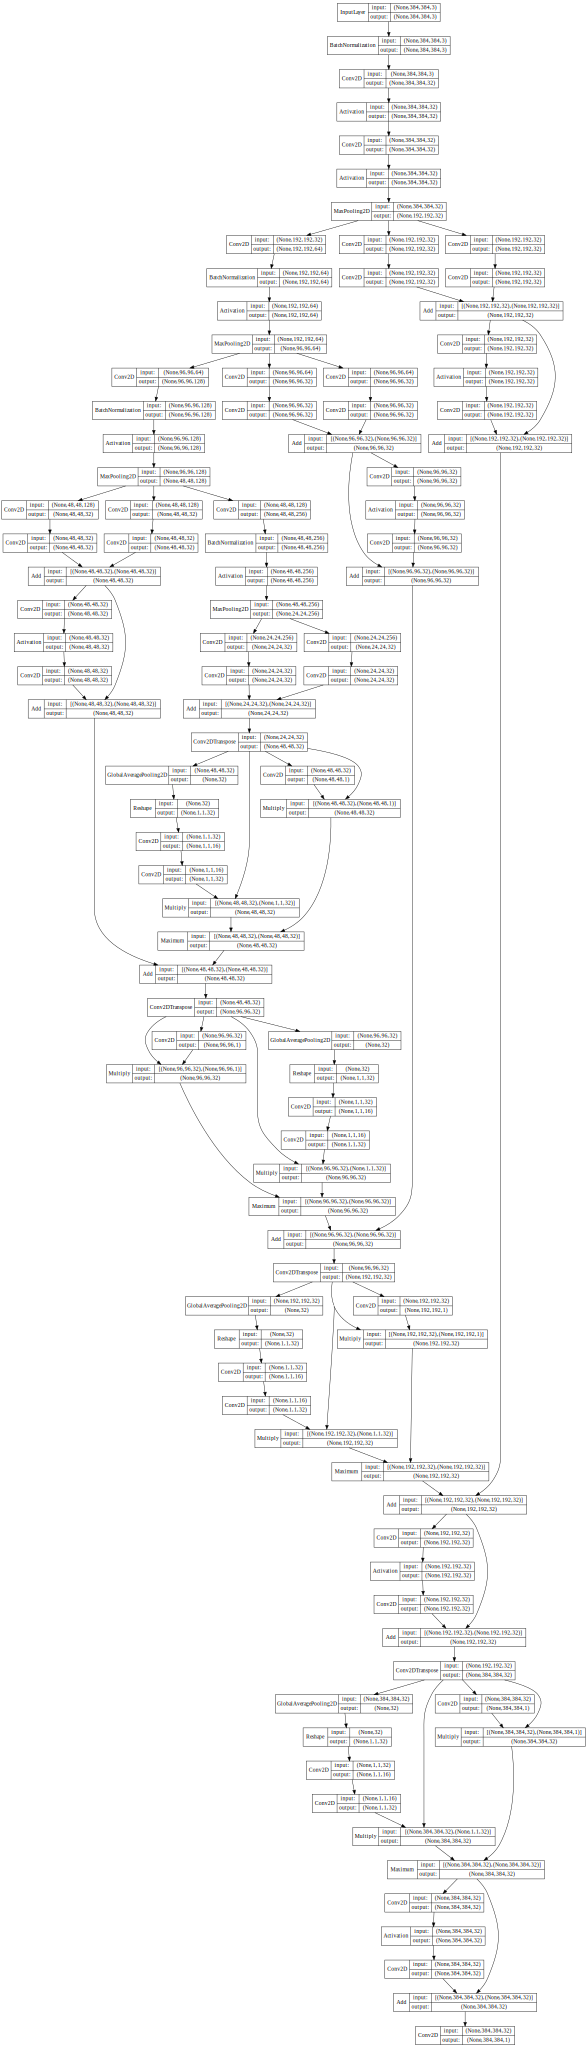

In [77]:
SVG(model_to_dot(seg_model, show_shapes=True, show_layer_names=False).create(prog='dot', format='svg'))

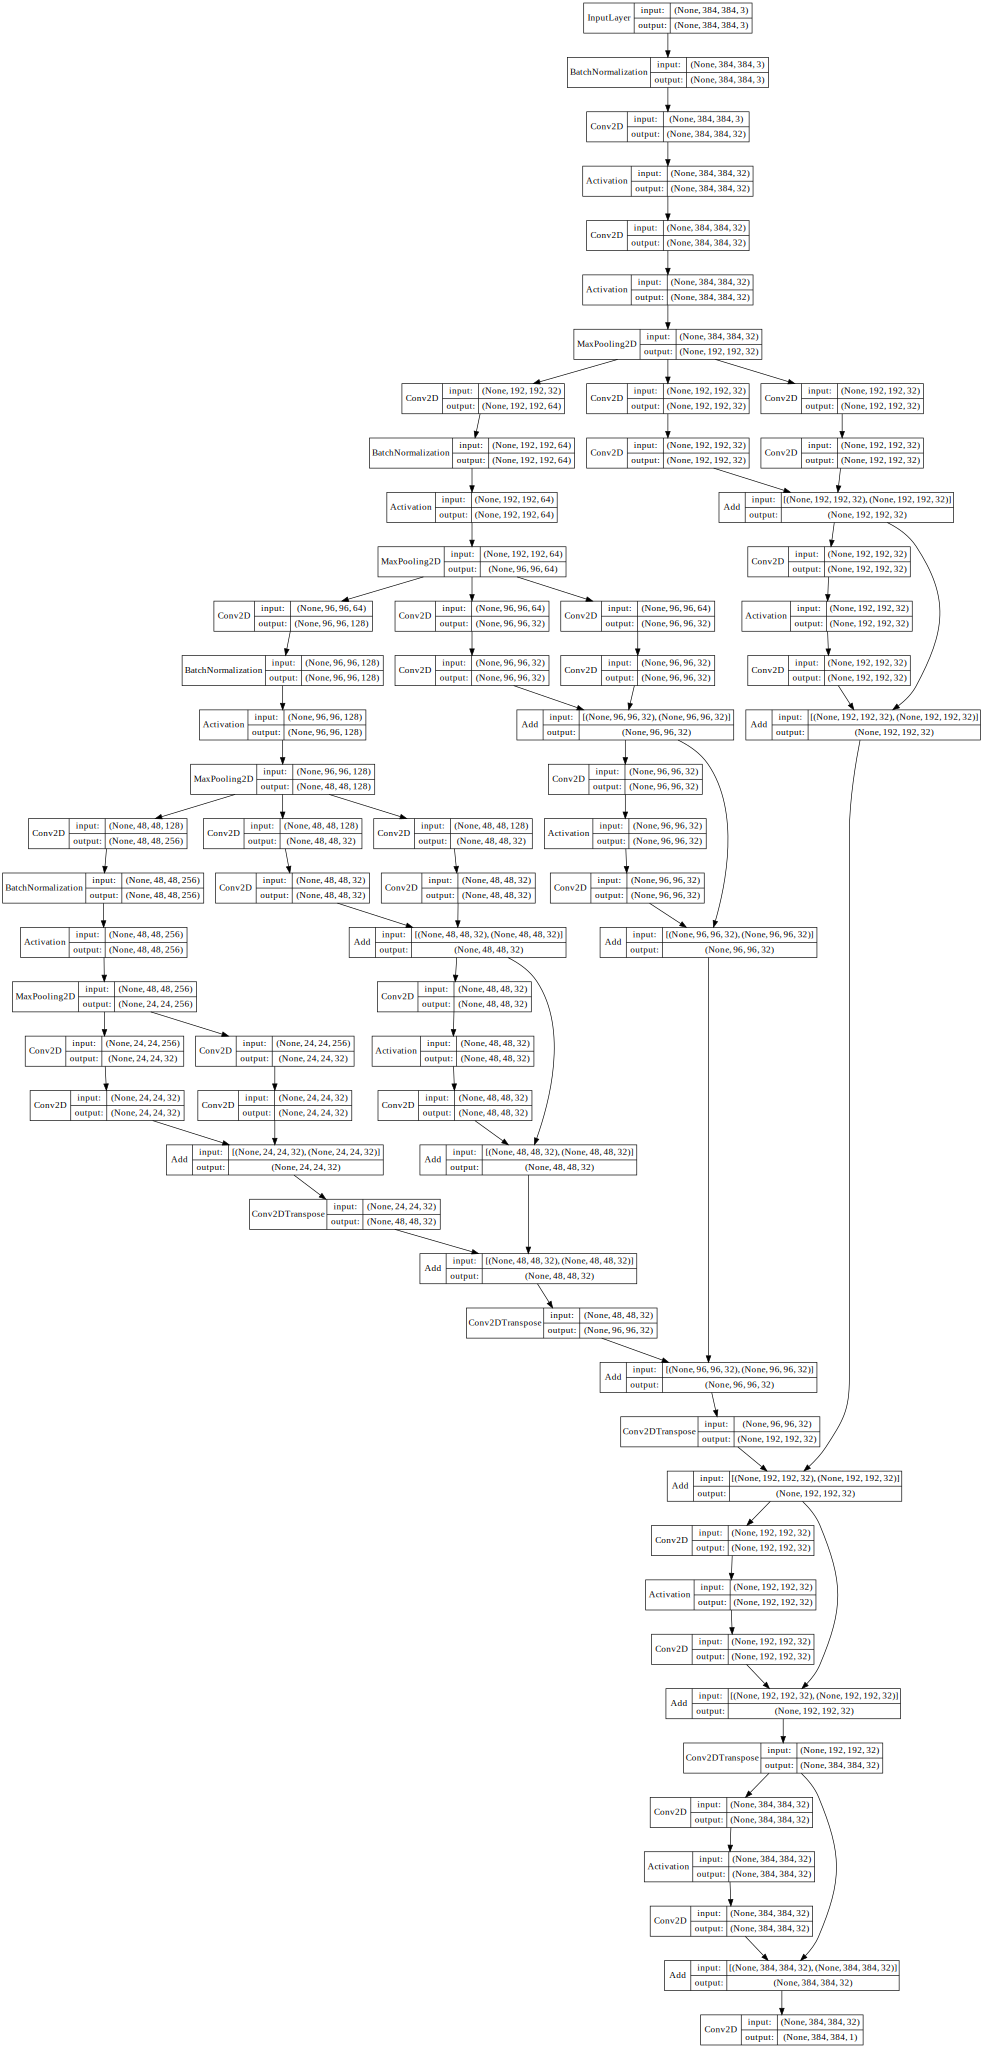

In [33]:
SVG(model_to_dot(seg_model, show_shapes=True, show_layer_names=False).create(prog='dot', format='svg'))

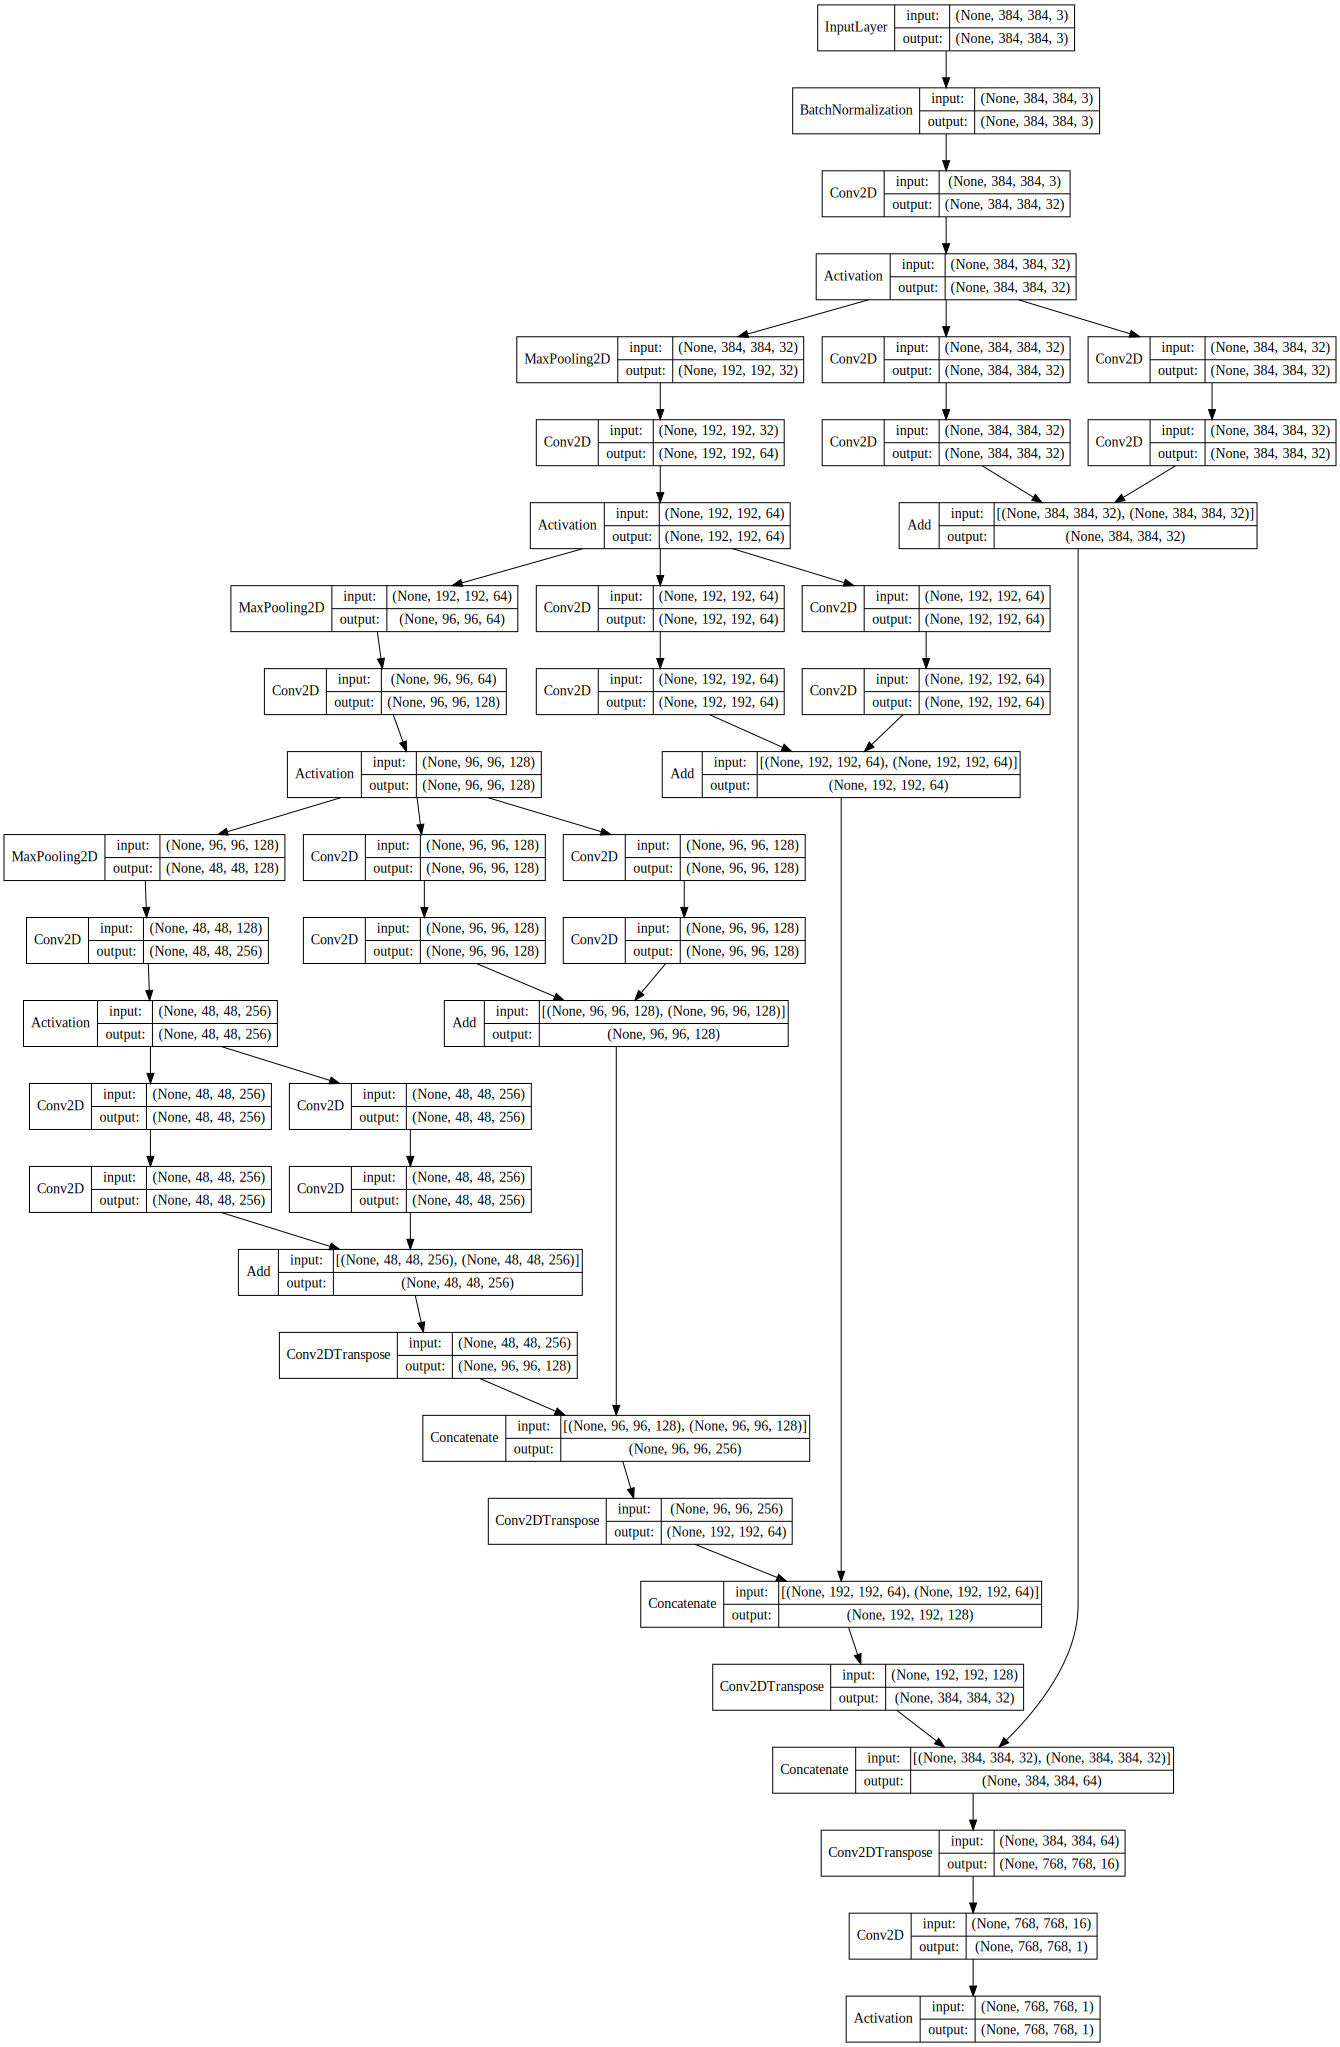

In [26]:
SVG(model_to_dot(seg_model, show_shapes=True, show_layer_names=False).create(prog='dot', format='svg'))

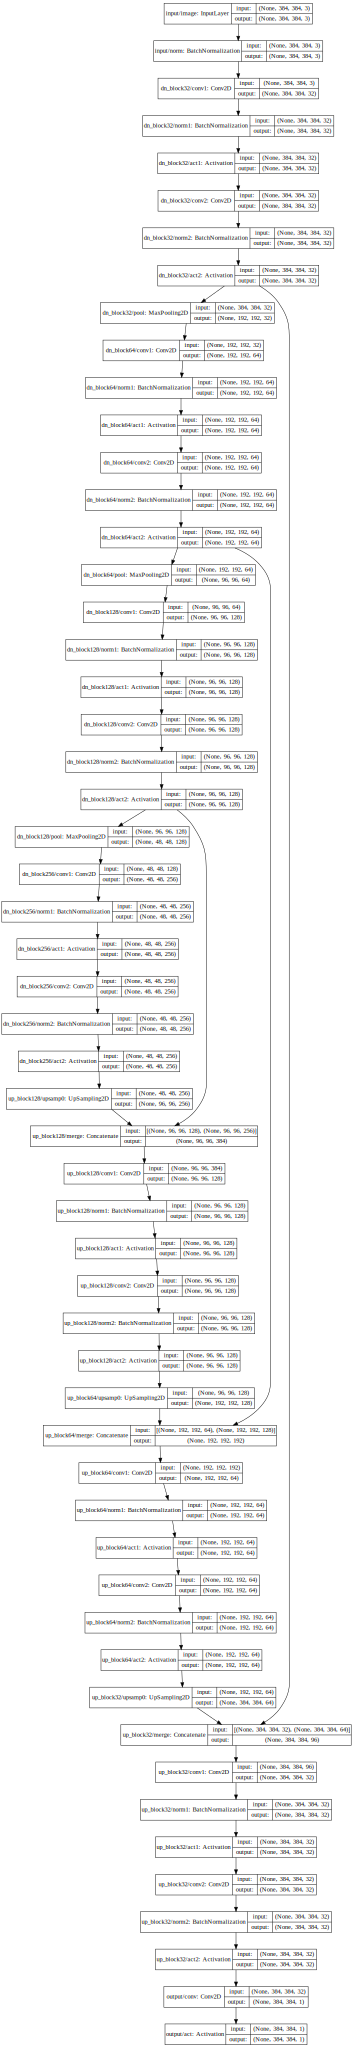

In [21]:
SVG(model_to_dot(seg_model, show_shapes=True).create(prog='dot', format='svg'))

In [11]:
from utils import get_best_model_name
best_model_name = get_best_model_name(BASE_MODEL)
seg_model = load_model(best_model_name, compile=False)

out/2018_1112_0051_06_GCN_scSE_384_focaldice_deconv/ship_model.034-0.0329.hdf5


In [ ]:
for i, layer in enumerate(seg_model.layers):
    layer.trainable = i >= n_frozen
    print(i+1, layer.name, layer.trainable)

In [15]:
from utils import get_best_model_name
best_model_name = get_best_model_name(BASE_MODEL)
trained_model = load_model(best_model_name, compile=False)

out/2018_1020_0657_01_bn0_128_focal_a06_g00/ship_model.065-0.3633.hdf5


In [ ]:
n_frozen = 5
for i, layer in enumerate(seg_model.layers):
#     layer.trainable = i >= n_frozen
#     if not layer.trainable:
#         layer.set_weights(trained_model.layers[i].get_weights())
#     if 'conv' not in layer.name:
#         continue
    print(i+1, layer.name, layer.trainable)
    weights = layer.get_weights()
    for w in weights:
        print('  ', w.shape, np.prod(w.shape), w.min(), w.max())

In [12]:
# https://github.com/keras-team/keras-contrib/blob/master/keras_contrib/losses/jaccard.py
def jaccard_distance(y_true, y_pred, smooth=100):
    """Jaccard distance for semantic segmentation, also known as the intersection-over-union loss.
    This loss is useful when you have unbalanced numbers of pixels within an image
    because it gives all classes equal weight. However, it is not the defacto
    standard for image segmentation.
    For example, assume you are trying to predict if each pixel is cat, dog, or background.
    You have 80% background pixels, 10% dog, and 10% cat. If the model predicts 100% background
    should it be be 80% right (as with categorical cross entropy) or 30% (with this loss)?
    The loss has been modified to have a smooth gradient as it converges on zero.
    This has been shifted so it converges on 0 and is smoothed to avoid exploding
    or disappearing gradient.
    Jaccard = (|X & Y|)/ (|X| + |Y| - |X & Y|)
            = sum(|A*B|)/(sum(|A|)+sum(|B|)-sum(|A*B|))
    # References
    Csurka, Gabriela & Larlus, Diane & Perronnin, Florent. (2013).
    What is a good evaluation measure for semantic segmentation?.
    IEEE Trans. Pattern Anal. Mach. Intell.. 26. . 10.5244/C.27.32.
    https://en.wikipedia.org/wiki/Jaccard_index
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

# CANT USE K.round IN LOSS FUNCTION. NOT DIFFERENTIABLE
def iou(y_true, y_pred, axis=-1, smooth=1e-3):
    isect = y_true * K.round(y_pred)
    i = K.sum(isect, axis=axis)
    u = K.sum(y_true + K.round(y_pred) - isect, axis=axis) + smooth
    return K.mean(i / u)

# CANT USE K.round IN LOSS FUNCTION. NOT DIFFERENTIABLE
def recall(y_true, y_pred, axis=-1, smooth=1e-3):
    isect = y_true * K.round(y_pred)
    i = K.sum(isect, axis=axis)
    t = K.sum(y_true, axis=axis) + smooth
    return K.mean(i / t)

def fbeta(y_true, y_pred, beta=2.0, axis=-1, smooth=1e-3):
    tp = K.sum(y_true * y_pred, axis=axis)
    fp = K.sum((1 - y_true) * y_pred, axis=axis)
    fn = K.sum(y_true * (1 - y_pred), axis=axis)
    return K.mean(((beta**2 + 1) * tp + smooth) / ((beta**2 + 1) * tp + beta**2 * fn + fp + smooth))

# CANT USE K.round IN LOSS FUNCTION. NOT DIFFERENTIABLE
def hard_dice_coef(y_true, y_pred, axis=-1, smooth=1e-3):
    return soft_dice_coef(K.round(y_true), K.round(y_pred), axis=axis, smooth=smooth)

def soft_dice_coef(y_true, y_pred, axis=-1, smooth=1e-3):
    AB = K.sum(y_true * y_pred, axis=axis)
    A = K.sum(y_true, axis=axis)
    B = K.sum(y_pred, axis=axis)
    return (2 * AB + smooth) / (A + B + smooth)

def soft_dice_loss(y_true, y_pred, axis=-1, smooth=1e-3):
    return 1 - soft_dice_coef(y_true, y_pred, axis=axis, smooth=smooth)

def bce_soft_dice_loss(y_true, y_pred, frac=0.5, mult=1):
    return binary_crossentropy(y_true, y_pred) * frac * mult + soft_dice_loss(y_true, y_pred) * (1 - frac) * mult

def bce_soft_dice_loss_wrapper(frac=0.5, mult=1):
    def bce_soft_dice_loss(y_true, y_pred):
        return binary_crossentropy(y_true, y_pred) * frac * mult + soft_dice_loss(y_true, y_pred) * (1 - frac) * mult
    return bce_soft_dice_loss

def focal_loss_wrapper(gamma=2., alpha=.25, axis=-1):
    def focal_loss(y_true, y_pred):
        y_pred_c = K.clip(y_pred, _EPSILON, 1.0 - _EPSILON)
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred_c, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred_c, tf.zeros_like(y_pred))
        res1 =      alpha  * K.pow(1. - pt_1, gamma) * K.log(     pt_1)
        res0 = (1 - alpha) * K.pow(     pt_0, gamma) * K.log(1. - pt_0)
        return -K.mean(res1 + res0, axis=axis)
    return focal_loss

def focal_soft_dice_loss_wrapper(gamma=2., alpha=.25, frac=0.5, mult=1):
    focal_loss = focal_loss_wrapper(gamma=gamma, alpha=alpha)
    def focal_soft_dice_loss(y_true, y_pred):
        return focal_loss(y_true, y_pred) * frac * mult + soft_dice_loss(y_true, y_pred) * (1 - frac) * mult
    return focal_soft_dice_loss

# def focal_soft_dice_loss_wrapper(gamma=2., alpha=.25, axis=-1):
#     focal_loss = focal_loss_wrapper(gamma=gamma, alpha=alpha, axis=axis)
#     def focal_soft_dice_loss(y_true, y_pred, axis=-1):
#         return focal_loss(y_true, y_pred) * 4 + soft_dice_loss(y_true, y_pred, axis=axis) * 6
#     return focal_soft_dice_loss

def brier_loss(y_true, y_pred):
    return K.sum((y_pred - y_true)**2, axis=-1)

loss_functions = {
    "brier_loss": brier_loss,
    "focal_loss": focal_loss_wrapper,
    "bce_soft_dice_loss": bce_soft_dice_loss_wrapper,
    "focal_soft_dice_loss": focal_soft_dice_loss_wrapper
}

In [13]:
focal_loss = focal_loss_wrapper()
seg_model.compile(
    optimizer=Adam(lr=LEARN_RATE), 
#     loss=bce_soft_dice_loss,
    loss=loss_functions[LOSS_FUNCTION](**LOSS_FUNCTION_KWARGS),
    metrics=[binary_crossentropy, focal_loss, fbeta])

In [14]:
os.makedirs(out_dir)

data_config_filename = os.path.join(out_dir, 'data_config.json')
with open(data_config_filename, 'w') as ofs:
    json.dump(data_config, ofs, indent=4)
    
model_config_filename = os.path.join(out_dir, 'model_config.json')
with open(model_config_filename, 'w') as ofs:
    json.dump(json.loads(seg_model.to_json()), ofs, indent=4)

model_summary_filename = os.path.join(out_dir, 'model_summary.png')
plot_model(seg_model, to_file=model_summary_filename, show_shapes=True, show_layer_names=True)

In [15]:
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
from keras.callbacks import CSVLogger
from keras.callbacks import Callback
from sklearn.metrics import fbeta_score

DEFAULT_THRESHOLDS = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
DEFAULT_BETA = 1
DEFAULT_LOGS = {}

def lr_decay_schedule(initial_lr=1e-3, decay_factor=0.001):
    '''
    Wrapper function to create a LearningRateScheduler with non-linear decay schedule.
    '''
    lr = initial_lr
    def schedule(epoch):
        nonlocal lr
        lr = lr * 1/(1 + decay_factor * epoch)
        return lr
    
    return LearningRateScheduler(schedule, verbose=1)

class FBetaMetricCallback(Callback):

    def __init__(self, beta=DEFAULT_BETA, thresholds=DEFAULT_THRESHOLDS):
        self.beta = beta
        self.thresholds = thresholds
#         self.val_fbeta = None
        self.fbeta_metric_name = f"val_f{beta}"
        self.axis = -1
        self.smooth = 1e-3
        
    def on_train_begin(self, logs=DEFAULT_LOGS):
        """ This is where the validation Fbeta
        validation scores will be saved during training: one value per
        epoch.
        """
#         self.val_fbeta = []
        pass
        
    def _fbeta(self, y_true, y_pred):
        tp = np.sum(y_true * y_pred, axis=self.axis)
        fp = np.sum((1 - y_true) * y_pred, axis=self.axis)
        fn = np.sum(y_true * (1 - y_pred), axis=self.axis)
        num = (self.beta ** 2 + 1) * tp
        denom = (self.beta ** 2 + 1) * tp + self.beta ** 2 * fn + fp
        return np.mean((num + self.smooth) / (denom + self.smooth))

    def _score_per_threshold(self, y_true, y_prob, threshold):
        """ Compute the Fbeta score per threshold.
        """
        # Notice that here I am using the sklearn fbeta_score function.
        # You can read more about it here:
        # http://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html
        y_pred = (y_prob > threshold).astype(int)
        return self._fbeta(y_true, y_pred)

    def on_epoch_end(self, epoch, logs=DEFAULT_LOGS):
        y_prob = self.model.predict(self.validation_data[0])
        y_true = self.validation_data[1]
        _val_fbeta = np.mean([self._score_per_threshold(y_true, y_prob, t) for t in self.thresholds])
        if self.fbeta_metric_name not in self.model.history.history:
            self.model.history.history[self.fbeta_metric_name] = []
        self.model.history.history[self.fbeta_metric_name].append(_val_fbeta)
#         self.val_fbeta.append(_val_fbeta)
        print("Current F{} metric is: {}".format(str(self.beta), str(_val_fbeta)))
        return

    def on_train_end(self, logs=DEFAULT_LOGS):
        """ Assign the validation Fbeta computed metric to the History object.
        """
#         self.model.history.history[self.fbeta_metric_name] = self.val_fbeta
        pass
        
        
best_weight_path = out_dir + "ship_model.{epoch:03d}-{val_loss:.4f}.hdf5"
last_weight_path = out_dir + "ship_model.last.hdf5"

f2_metric_callback = FBetaMetricCallback(beta=2)

best_model_checkpointer = ModelCheckpoint(
    best_weight_path, 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False, 
    monitor='val_loss', 
    mode='min')

last_model_checkpointer = ModelCheckpoint(
    last_weight_path, 
    verbose=1, 
    save_best_only=False, 
    save_weights_only=False, 
    monitor='val_loss', 
    mode='min')

tensorboard = TensorBoard(
    log_dir=f"./logs/{run_name}", 
    histogram_freq=0, 
    batch_size=64, 
    write_graph=False, 
    write_grads=False, 
    write_images=False
)
# reduceLROnPlat = ReduceLROnPlateau(
#     monitor='val_loss', 
#     factor=0.5, 
#     patience=7, 
#     verbose=1, 
#     mode='min', 
#     min_delta=0.0001, 
#     cooldown=5, 
#     min_lr=1e-5)

epochs = 100

learning_rate_scheduler = lr_decay_schedule(initial_lr=LEARN_RATE, decay_factor=0.002)

logger = CSVLogger(out_dir + 'training_stats.csv')

In [16]:
seg_model.fit_generator(
    train_gen, 
    steps_per_epoch=len(train_gen),
    epochs=epochs, 
    validation_data=(x_valid, y_valid),
    callbacks=[
#         f2_metric_callback, 
        best_model_checkpointer, 
        last_model_checkpointer,
        learning_rate_scheduler,
        logger, 
        tensorboard,
    ],
#     use_multiprocessing=True,
#     workers=16
)
print(get_datetime_now())

Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to 0.0015.
8192/8192 [==============================] - 4389s 536ms/step - loss: 0.0269 - binary_crossentropy: 0.0096 - focal_loss: 0.0020 - fbeta: 0.9956 - val_loss: 0.0297 - val_binary_crossentropy: 0.0084 - val_focal_loss: 0.0020 - val_fbeta: 0.9945

Epoch 00001: val_loss improved from inf to 0.02972, saving model to out/2018_1112_2205_24_GCN_scSE_768_focaldice_deconv/ship_model.001-0.0297.hdf5

Epoch 00001: saving model to out/2018_1112_2205_24_GCN_scSE_768_focaldice_deconv/ship_model.last.hdf5
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 0.0014970059880239522.
8192/8192 [==============================] - 4361s 532ms/step - loss: 0.0250 - binary_crossentropy: 0.0089 - focal_loss: 0.0019 - fbeta: 0.9958 - val_loss: 0.0265 - val_binary_crossentropy: 0.0076 - val_focal_loss: 0.0016 - val_fbeta: 0.9948

Epoch 00002: val_loss improved from 0.02972 to 0.02653, saving model to out/2018_1112_2

8192/8192 [==============================] - 4332s 529ms/step - loss: 0.0191 - binary_crossentropy: 0.0066 - focal_loss: 0.0013 - fbeta: 0.9966 - val_loss: 0.0174 - val_binary_crossentropy: 0.0069 - val_focal_loss: 0.0015 - val_fbeta: 0.9974

Epoch 00017: val_loss did not improve from 0.01706

Epoch 00017: saving model to out/2018_1112_2205_24_GCN_scSE_768_focaldice_deconv/ship_model.last.hdf5
Epoch 18/100

Epoch 00018: LearningRateScheduler setting learning rate to 0.0011084625485626159.
8192/8192 [==============================] - 4356s 532ms/step - loss: 0.0186 - binary_crossentropy: 0.0064 - focal_loss: 0.0013 - fbeta: 0.9966 - val_loss: 0.0175 - val_binary_crossentropy: 0.0071 - val_focal_loss: 0.0015 - val_fbeta: 0.9976

Epoch 00018: val_loss did not improve from 0.01706

Epoch 00018: saving model to out/2018_1112_2205_24_GCN_scSE_768_focaldice_deconv/ship_model.last.hdf5
Epoch 19/100

Epoch 00019: LearningRateScheduler setting learning rate to 0.0010699445449446098.
8192/8192 [=

KeyboardInterrupt: 

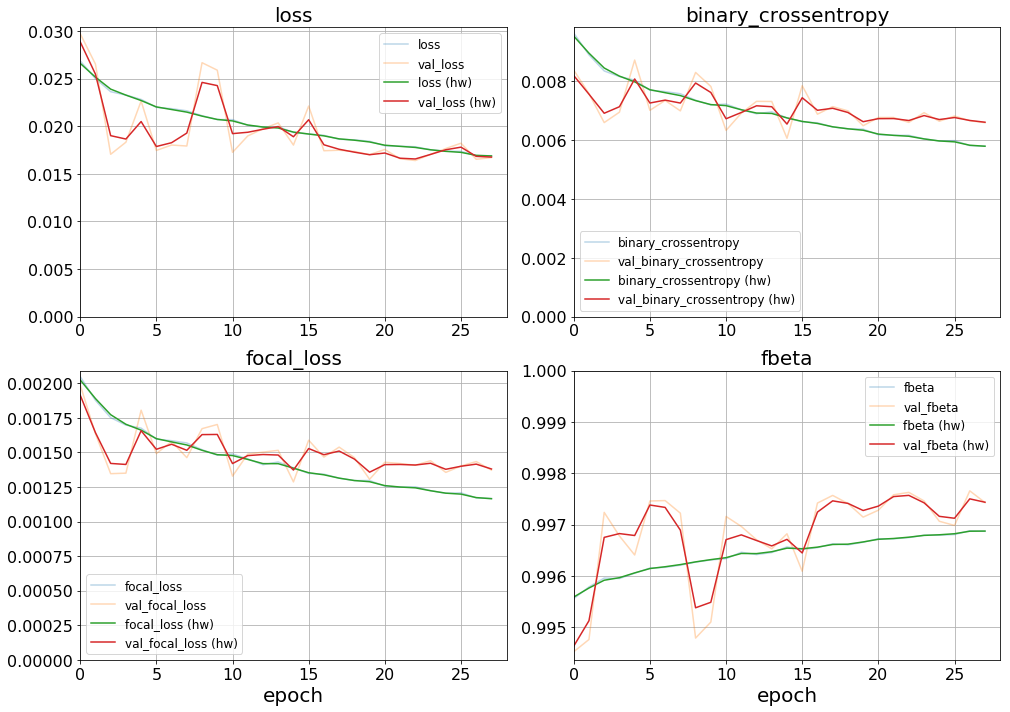

In [17]:
nrows = 2
ncols = 2
df_stats = pd.read_csv(out_dir + 'training_stats.csv')
if 'val_f2' in seg_model.history.history and 'val_f2' not in df_stats:
    df_stats['val_f2'] = seg_model.history.history['val_f2']

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 10))
# span = 111//30 = 3
# span = epochs // 100
span = 2
field_ylim = {
    'loss': (0, None), 
    'brier_loss': (0, None),
    'focal_loss': (0, None), 
    'focal_loss_1': (0, 5), 
    'focal_loss_2': (0, 5), 
    'dice_coef_loss': (0, None), 
    'soft_dice_loss': (0, None),
    'binary_crossentropy': (0, None),
    'acc': (None, 1), 
    'iou': (None, 1), 
    'mean_iou': (None, 1), 
    'f2': (None, 1), 
    'fbeta': (None, 1), 
    'soft_dice_coef': (None, 1),
    'hard_dice_coef': (None, 1), 
    'hard_dice_coef2': (None, 1), 
    'hard_dice_coef_ch1': (None, 1),
} 
stats_fields = (('loss', 'binary_crossentropy'), ('focal_loss', 'fbeta'))
filename = []
for i in range(nrows):
    for j in range(ncols):
        field = stats_fields[i][j]
        filename.append(field)
        
        stats_dict = {
            field: df_stats[field],
            'val_'+field: df_stats['val_'+field],
            field+' (hw)': reversed_recombined_holt_winters(np.array(df_stats[field]), span=span),
            'val_'+field+' (hw)': reversed_recombined_holt_winters(np.array(df_stats['val_'+field]), span=span)
        }
        alphas = {
            field: 0.3,
            'val_'+field: 0.3,
            field+' (hw)': 1,
            'val_'+field+' (hw)': 1
        }
        ax = axes[i][j]
        legend_labels = []
        for key, value in stats_dict.items():
            ax.plot(value, alpha=alphas[key])
            legend_labels.append(key)
        # Special case for f2 callback.
        if field == 'fbeta' and 'val_f2' in df_stats:
            ax.plot(df_stats['val_f2'])
            legend_labels.append('val_f2')
        ax.set_title(field)
        if i == nrows - 1:
            ax.set_xlabel(r'epoch')
        ax.set_xlim((0, len(df_stats[field])))
        ax.set_ylim(field_ylim[field])
        ax.grid(True)
        ax.legend(legend_labels)

filename = '-'.join(filename)
plt.tight_layout()
plt.savefig(out_dir + filename + '.png')
plt.show()